In [149]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus.reader.wordnet import NOUN,VERB
import nltk
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

from xgboost import XGBClassifier,XGBRFClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV,StratifiedKFold

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [469]:
articles_list = []
topics_list =[]
rt_list=[]
for file in os.listdir("reuters21578/"):
    
    if file.endswith(".sgm"):
        
        # for each sgm file, read it
        filename = os.path.join("reuters21578", file)
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read()
        
        # pass it to BeautifulSoup
        soup = BeautifulSoup(dataFile, 'html.parser')
        contents = soup.findAll('body')
        topics=soup.findAll('topics')
        # for each body tag, extract it's text
        rt=soup.findAll('reuters')
        for content in contents:
            articles_list.append(content.text)
        for topic in topics:
            topics_list.append(topic.text)
        for r in rt:
            r=str(r).split("\n")[0].split()[2].split("=")[1].translate(str.maketrans('', '', string.punctuation))
            rt_list.append(r) 

In [471]:
df=pd.DataFrame(list(zip(articles_list,topics_list,rt_list)),columns=["articles","topic","type"])

In [472]:
df.head()

,articles,topic,type
0,Showers continued throughout the week in\nthe ...,cocoa,TRAIN
1,Standard Oil Co and BP North America\nInc said...,,TRAIN
2,Texas Commerce Bancshares Inc's Texas\nCommerc...,,TRAIN
3,BankAmerica Corp is not under\npressure to act...,,TRAIN
4,The U.S. Agriculture Department\nreported the ...,grainwheatcornbarleyoatsorghum,TRAIN


In [228]:
df.shape

(18583, 2)

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18583 entries, 0 to 18582
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   articles  18583 non-null  object
 1   topic     18583 non-null  object
 2   type      18583 non-null  object
dtypes: object(3)
memory usage: 435.7+ KB


In [474]:
df.type.value_counts()

TRAIN        14665
TEST          3192
NOTUSED        722
539010540        1
540385847        1
539378419        1
855360000        1
Name: type, dtype: int64

In [477]:
df.describe(include="all").T

,count,unique,top,freq
articles,18583,18321,The Bundesbank left credit policies\nunchanged...,4
topic,18583,611,,8566
type,18583,7,TRAIN,14665


In [487]:
df_train=df[df["type"]=="TRAIN"]
df_test=df[df["type"]=="TEST"]

### Cleaning the articles

In [488]:
df1=df_train.copy()

In [489]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [490]:
df1["articles"] = df1["articles"].apply(lambda x:  re.sub("http\s+", '', x))
# remove html tags
df1["articles"] = df1["articles"].apply(lambda x:  re.sub("<[^<]+?>", '', x))

df1["articles"]=df1["articles"].apply(lambda x: decontracted(x))
# remove special characters, numbers and punctuations
df1["articles"] = df1["articles"].apply(lambda x:  re.sub("[^A-za-z+ ]", ' ', x))
#lower the text
df1["articles"] = df1["articles"].apply(lambda x:  x.lower())

In [491]:
lemmatizer=WordNetLemmatizer()

In [492]:
df1["articles"]=df1["articles"].apply(lambda x: " ".join([lemmatizer.lemmatize(w,NOUN) for w in word_tokenize(x)]))
df1["articles"]=df1["articles"].apply(lambda x: " ".join([lemmatizer.lemmatize(w,VERB) for w in word_tokenize(x)]))

In [217]:
remove=["mln","dlr","pct","said","bank","cts","vs"]

In [212]:
s="showers continued throughout week bahia cocoa zone alleviating drought since improving prospects coming temporao normal humidity levels restored smith said weekly dry period means temporao late arrivals week ended february kilos making cumulative total season stage last cocoa delivered earlier consignment included comissaria smith said still doubt old crop cocoa still available harvesting come total bahia crop mln bags sales standing almost mln hundred thousand bags still hands farmers exporters doubts much cocoa would export shippers experiencing dificulties bahia superior view lower quality recent weeks farmers good part cocoa held comissaria smith said spot bean prices rose per arroba bean shippers reluctant offer nearby shipment limited sales booked march shipment dlrs per tonne ports new crop sales also light open ports going dlrs new york july tonne routine sales butter sold butter went times new york may dlrs dlrs times new york sept dlrs times new york dec comissaria smith destinations covertible currency areas open cake sales registered dlrs dlrs may dlrs aug york dec buyers argentina uruguay liquor sales limited selling dlrs dlrs times july dlrs times new times new york dec comissaria total bahia sales currently estimated mln crop mln bags final figures period february expected published brazilian cocoa trade commission ends midday february"

In [493]:
# removing stop-words
stop_words=stopwords.words("English")


df1["articles"] = df1["articles"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if len(w)!=1 and w not in stop_words))


In [494]:
df1["articles"]=df1["articles"].apply(lambda x: " ".join(x.split()[:100]))

In [496]:
#some examples after cleaning the articles
for i in range(5):
    print(f"example{i} ={df1['articles'][i]}\n")


example0 =shower continue throughout week bahia cocoa zone alleviate drought since early january improve prospect come temporao although normal humidity level restore comissaria smith say weekly review dry period mean temporao late year arrival week end february bag kilo make cumulative total season mln stage last year seem cocoa deliver earlier consignment wa include arrival figure comissaria smith say still doubt much old crop cocoa still available harvest ha practically come end total bahia crop estimate around mln bag sale stand almost mln hundred thousand bag still hand farmer middleman exporter processor doubt much cocoa would fit export shipper experience dificulties

example1 =standard oil co bp north america inc say plan form venture manage money market borrow investment activity company bp north america subsidiary british petroleum co plc also pct interest standard oil venture call bp standard financial trade operate standard oil oversight joint management committee reuter

e

### EDA

In [242]:
df1["topic"].value_counts()

                                                                                     8566
earn                                                                                 3443
acq                                                                                  2032
trade                                                                                 335
crude                                                                                 326
                                                                                     ... 
oilseedsoybeansoy-oil                                                                   1
meal-feedsoy-mealtapiocagraincorncornglutenfeedcitruspulpoilseedrapeseedrape-meal       1
tradehogcarcasslivestock                                                                1
tradegnpbopreservesmoney-fx                                                             1
soybeangrainwheatcorn                                                                   1
Name: topi

In [241]:
df1[df1["topic"]=="trade"]["articles"].tolist()

['the panama canal commission government agency say in it daily operation report that there wa backlog of ship wait to enter the canal early today over the next two day it expect due schedule to transit end day backlog average wait time tomorrow super tanker regular vessel north end hr hr south end hr hr reuter',
 'caisse aide equipement de collective locale caecl be issue billion yen eurobond due march pay pct and price at pct lead manager mitsubishi trust international ltd say the non callable bond be available in denomination of one mln yen and will be list in luxembourg the sell concession be pct while management and underwrite combine pay pct the payment date be march reuter',
 'brazil would not have suspend payment on debt owe to foreign bank if it have receive more and faster finance from official lend agency finance minister dilson funaro say he say he would not seek more money from the international monetary fund to which brazil pay mln dlrs last year and say brazil be problem

In [131]:
len(df[df["topic"]==""])

8566

In [197]:
df["topic"].value_counts(normalize=True)[:10]

                0.460959
earn            0.185277
acq             0.109347
trade           0.018027
crude           0.017543
money-fx        0.013830
interest        0.013399
money-supply    0.008233
grainwheat      0.007480
sugar           0.007426
Name: topic, dtype: float64

#### Ngrams

In [371]:
trade=df1[df1["topic"]=="grainwheat"]

In [373]:
trade

,articles,topic,new
179,farmer past grow oat use fail certify governme...,grainwheat,a a r a s a e o r l o l r l o r e i g e i y a ...
240,indonesia raw sugar output likely mln tonne ca...,grainwheat,n a u u i l o a n o o l m a g u n u o a u o a ...
252,nippon light metal co ltd ha annual capacity t...,grainwheat,i i e o t a n a o o r l r a o w o o o r o a u ...
253,saudi crude oil output last month fell average...,grainwheat,a r i u a o e v l a e a p l p a u i o a a x a ...
741,federal government expenditure rise pct fiscal...,grainwheat,e o x i c i e e p i l i l i r o a o o r a s o ...
...,...,...,...
18274,military planner rule iran silkworm missile ta...,grainwheat,i l u r i i a e t o o e r e r r a e i a x a a ...
18296,shr profit two ct nil net profit loss rev nine...,grainwheat,h r w t i e r o e i t h o n t o o t e o o e l ...
18376,brazil september trade surplus wa best far yea...,grainwheat,r e r u a e a e o i l o i l u l l e a e a r o ...
18399,first republicbank corp largest bank hold comp...,grainwheat,i e o a a o o e e o l l h u a o e o i h e e e ...


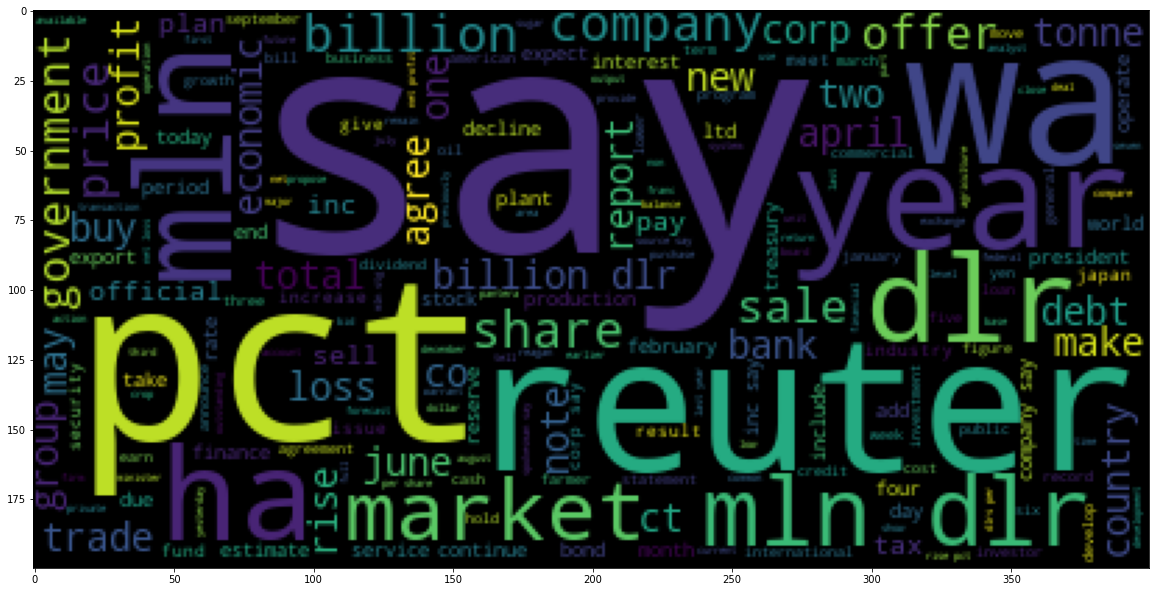

In [374]:
total_articles=" ".join(art for art in trade["articles"].tolist())
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(total_articles))

In [ ]:
# top n-grams where topic is earn

In [377]:
df_earn=df1[df1["topic"].str.contains("earn")]
df_others=df1[~df1["topic"].str.contains("earn")]

In [378]:
def generateNGrams(n):
    n_gram = []
    for doc in df_earn["articles"].values:
        tokens = [token for token in doc.split(" ") if token != ""]
        output = set(ngrams(tokens, n))
        n_gram.append(output)
    return n_gram

In [101]:
from nltk.util import ngrams

In [379]:
n_gram = generateNGrams(2)
print(n_gram[0])

{('director', 'approve'), ('mln', 'mln'), ('annual', 'meet'), ('two', 'one'), ('april', 'increase'), ('company', 'also'), ('record', 'april'), ('also', 'say'), ('split', 'common'), ('recommend', 'shareholder'), ('champion', 'product'), ('common', 'share'), ('five', 'mln'), ('april', 'company'), ('increase', 'authorize'), ('vote', 'recommend'), ('inc', 'say'), ('share', 'reuter'), ('one', 'stock'), ('shareholder', 'record'), ('mln', 'share'), ('stock', 'split'), ('meet', 'april'), ('authorize', 'capital'), ('say', 'board'), ('shareholder', 'annual'), ('share', 'shareholder'), ('approve', 'two'), ('capital', 'stock'), ('product', 'inc'), ('board', 'director'), ('board', 'vote'), ('stock', 'five')}


In [106]:
n_gram = generateNGrams(2)
print(n_gram[0])

{('booked', 'march'), ('view', 'lower'), ('mln', 'crop'), ('good', 'part'), ('butter', 'sold'), ('week', 'ended'), ('mln', 'bags'), ('coming', 'temporao'), ('making', 'cumulative'), ('shipment', 'limited'), ('sold', 'butter'), ('thousand', 'bags'), ('limited', 'sales'), ('almost', 'mln'), ('sales', 'registered'), ('liquor', 'sales'), ('bean', 'shippers'), ('argentina', 'uruguay'), ('weeks', 'farmers'), ('estimated', 'mln'), ('ports', 'going'), ('offer', 'nearby'), ('old', 'crop'), ('nearby', 'shipment'), ('open', 'ports'), ('mln', 'hundred'), ('tonne', 'routine'), ('new', 'york'), ('showers', 'continued'), ('currently', 'estimated'), ('buyers', 'argentina'), ('late', 'arrivals'), ('dlrs', 'times'), ('still', 'hands'), ('recent', 'weeks'), ('crop', 'mln'), ('included', 'comissaria'), ('smith', 'destinations'), ('midday', 'february'), ('consignment', 'included'), ('means', 'temporao'), ('earlier', 'consignment'), ('lower', 'quality'), ('dlrs', 'aug'), ('per', 'tonne'), ('humidity', 'leve

In [17]:
df_earn.shape

(3485, 2)

In [107]:
total_articles=" ".join(art for art in df_earn["articles"].tolist())

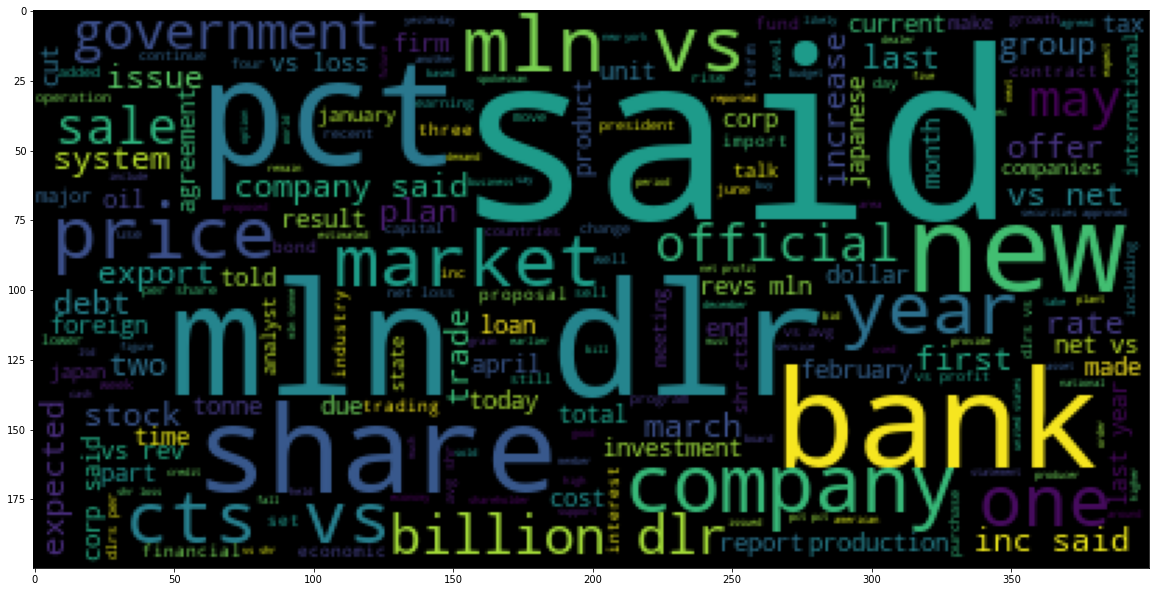

In [108]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(total_articles))

In [111]:
total_articles=[]
total_articles=" ".join(art for art in df_others["articles"].tolist())

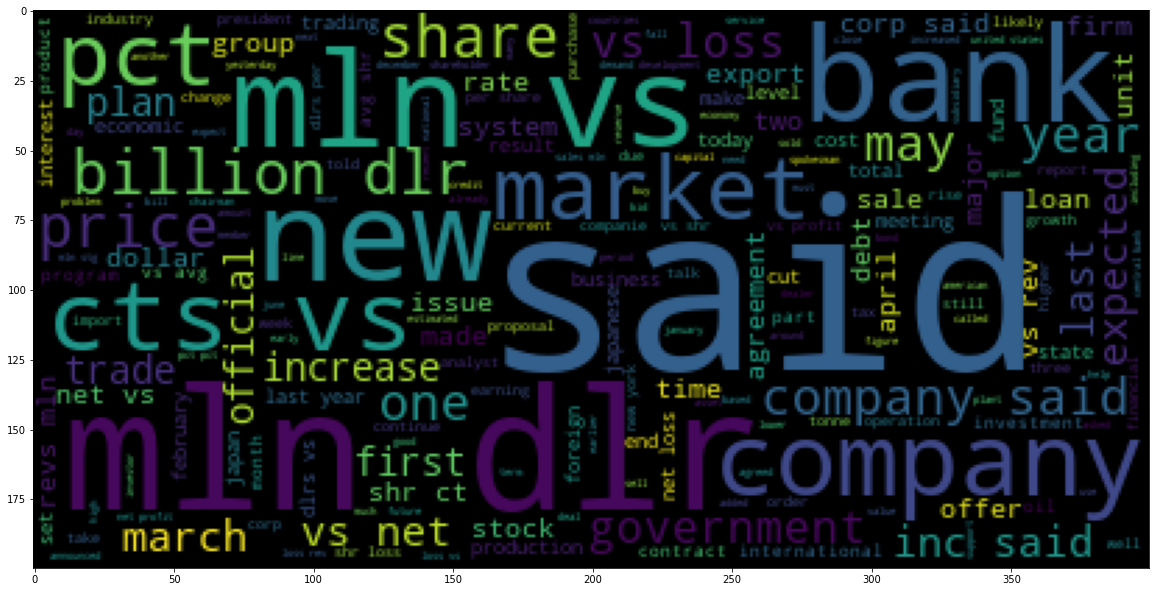

In [112]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(total_articles))

In [18]:
tfidf_earn=TfidfVectorizer(stop_words='english',ngram_range=(2,4),min_df=5)
tfs_earn=tfidf_earn.fit_transform(df_earn["articles"].values)

feature_names= tfidf_earn.get_feature_names()
rows,cols=tfs_earn.nonzero()

In [19]:
features=Counter(cols)
n_grams_dict={}
for k,v in features.items():
    n_grams_dict[feature_names[k]]=v
df_ngrams=pd.DataFrame(n_grams_dict.items(),columns=["ngrams","frequency"])

In [20]:
df_ngrams.sort_values("frequency",ascending=False)[:25]

,ngrams,frequency
168,mln dlrs,536
38,cts vs,400
9,company said,363
33,mln vs,284
339,corp said,273
139,billion dlrs,241
37,vs net,219
90,vs shr,188
23,shr cts vs,186
39,shr cts,186


In [257]:
df_others=df[(~df["topic"].str.contains("earn")) & (df["topic"]!="")]

In [23]:
tfidf_others=TfidfVectorizer(stop_words='english',ngram_range=(2,4),min_df=5)
tfs_others=tfidf_others.fit_transform(df_others["articles"].values)

feature_names= tfidf_others.get_feature_names()
rows,cols=tfs_others.nonzero()

In [24]:
features=Counter(cols)
n_grams_others_dict={}
for k,v in features.items():
    n_grams_others_dict[feature_names[k]]=v
df_ngrams_other=pd.DataFrame(n_grams_others_dict.items(),columns=["ngrams","frequency"])

In [25]:
df_ngrams_other.sort_values("frequency",ascending=False)[:25]

,ngrams,frequency
82,mln dlrs,1020
176,cts vs,853
32,company said,745
444,mln vs,589
54,corp said,539
218,vs net,457
84,billion dlrs,412
221,vs shr,404
408,shr cts,366
407,shr cts vs,366


### Modelling

In [497]:
df1=df1[df1["topic"]!=""]

In [498]:
df1["label"]=df1["topic"].apply(lambda x: "earn" if x=="earn" else "others")

d:\anaconda\envs\glm\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [499]:
df1["label"].value_counts()

others    4939
earn      2840
Name: label, dtype: int64

In [500]:
X=df1["articles"]
y=df1["label"]

In [501]:
td = TfidfVectorizer(max_features = 5000,stop_words='english',ngram_range=(2,4),min_df=5)
X = td.fit_transform(X).toarray()

In [503]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [504]:
from sklearn.metrics import accuracy_score, classification_report
class_rep=classification_report(y_test, y_pred)

In [505]:
accuracy_score(y_test,y_pred)

0.6041131105398457

In [506]:
print(class_rep)

              precision    recall  f1-score   support

        earn       0.38      0.12      0.18       857
      others       0.63      0.89      0.74      1477

    accuracy                           0.60      2334
   macro avg       0.50      0.50      0.46      2334
weighted avg       0.54      0.60      0.53      2334



In [507]:
XG_model=XGBClassifier()
XG_model.fit(X_train,y_train)

d:\anaconda\envs\glm\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [508]:
xgb_score=get_metrics_score(XG_model)

Accuracy on training set :  0.7856749311294766
Accuracy on test set :  0.5951156812339332


In [509]:
y_pred = XG_model.predict(X_test)

In [393]:
class_rep=classification_report(y_test, y_pred)
print(class_rep)

              precision    recall  f1-score   support

        earn       0.36      0.10      0.15      1022
      others       0.66      0.91      0.77      1984

    accuracy                           0.63      3006
   macro avg       0.51      0.50      0.46      3006
weighted avg       0.56      0.63      0.56      3006



In [116]:
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
 
    
#     score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        
    
    return score_list # returning the list with train and test scores

In [400]:
earn=df1[df1["label"]=="earn"]["articles"].tolist()
others=df1[df1["label"]=="others"]["articles"].tolist()

In [404]:
df[df["topic"]=="earn"]["articles"].tolist()[:2]

['Champion Products Inc said its\nboard of directors approved a two-for-one stock split of its\ncommon shares for shareholders of record as of April 1, 1987.\n    The company also said its board voted to recommend to\nshareholders at the annual meeting April 23 an increase in the\nauthorized capital stock from five mln to 25 mln shares.\n Reuter\n\x03',
 'Shr 34 cts vs 1.19 dlrs\n    Net 807,000 vs 2,858,000\n    Assets 510.2 mln vs 479.7 mln\n    Deposits 472.3 mln vs 440.3 mln\n    Loans 299.2 mln vs 327.2 mln\n    Note: 4th qtr not available. Year includes 1985\nextraordinary gain from tax carry forward of 132,000 dlrs, or\nfive cts per shr.\n Reuter\n\x03']

In [401]:
earn

['champion product inc say board director approve two one stock split common share shareholder record april company also say board vote recommend shareholder annual meet april increase authorize capital stock five mln mln share reuter',
 'shr ct dlrs net asset mln mln deposit mln mln loan mln mln note th qtr available year include extraordinary gain tax carry forward dlrs five ct per shr reuter',
 'oper shr loss two ct profit seven ct oper shr profit profit rev mln mln avg shrs mln mln six mths oper shr profit nil profit ct oper net profit profit rev mln mln avg shrs mln mln note per shr calculate payment prefer dividend result exclude credit four ct nine ct qtr six mths six ct ct prior period operate loss carryforwards reuter',
 'shr one dlr ct net mln mln rev mln mln nine mths shr dlrs dlrs net mln mln rev billion mln reuter',
 'dean food co expect earn fourth quarter end may exceed year ago period chairman kenneth douglas tell analyst fiscal fourth quarter food processor report earn

In [397]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(earn))

TypeError: expected string or bytes-like object

<Figure size 1440x1440 with 0 Axes>